In [1]:
#Importando librerias
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import os
import matplotlib.image as mpimg
import pandas as pd


In [2]:
!pip install rasterio
import rasterio as rio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.0 MB/s eta 0:00:00


In [3]:
!pip install shapely
from shapely.geometry import box

In [5]:
# Ruta del archivo zip
zip_paths = ['/content/09_ciudaddemexico.zip', '/content/13_hidalgo.zip', '/content/15_mexico.zip']
# Descomprimir el archivo zip
with zipfile.ZipFile(zip_paths[0], 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')
with zipfile.ZipFile(zip_paths[1], 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')
with zipfile.ZipFile(zip_paths[2], 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [40]:
# Cargar el shapefile en este primer approach usamos el estado
agebsCDMX = gpd.read_file('/content/sample_data/conjunto_de_datos/09a.shp')
agebsHidalgo = gpd.read_file('/content/sample_data/conjunto_de_datos/13a.shp')
agebsEdoMex = gpd.read_file('/content/sample_data/conjunto_de_datos/15a.shp')
# Unir los tres GeoDataFrames
agebs_unidos = gpd.GeoDataFrame(pd.concat([agebsCDMX, agebsHidalgo, agebsEdoMex], ignore_index=True))


# Cargar el archivo CSV con la columna AGEB
df_csv = pd.read_csv('/content/AGEBS_COMUNES_UNICOS.csv')
print(df_csv.head())

# Ensure 'CVE_AGEB' in both DataFrames have the same data type
# Convert 'CVE_AGEB' in agebs_unidos to string if it's not already
agebs_unidos['CVE_AGEB'] = agebs_unidos['CVE_AGEB'].astype(str)
# Convert 'CVE_AGEB' in df_csv to string if it's not already
df_csv['CVE_AGEB'] = df_csv['CVE_AGEB'].astype(str)

# Combinar los DataFrames (asumiendo que la columna AGEB en ambos tiene el mismo nombre)
agebs_unidos = pd.merge(agebs_unidos, df_csv, on='CVE_AGEB', how='inner')

# Convertir nuevamente a GeoDataFrame si es necesario
agebs_unidos = gpd.GeoDataFrame(agebs_unidos, geometry=agebs_unidos.geometry)

# Guardar el shapefile resultante con los AGEBs filtrados
agebs_unidos.to_file('/content/sample_data/agebs_filtrados.shp')


# Calcular los centroides y agregarlos al GeoDataFrame
agebs_unidos['centroid'] = agebs_unidos['geometry'].centroid

# Crear un nuevo GeoDataFrame solo con los centroides
centroides = gpd.GeoDataFrame(agebs_unidos['centroid'], geometry='centroid')

# Guardar el nuevo GeoDataFrame
centroides.to_file("centroides_agebs.shp")

   CVE_AGEB  POBTOT  Promedio_POBTOT
0        43      92               92
1       125      27               27
2       214      32               32
3       229     196              196
4       252       0                0


<ipython-input-40-51b326afacdb>:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  agebs_unidos.to_file('/content/sample_data/agebs_filtrados.shp')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Promedio_POBTOT' to 'Promedio_P'
  ogr_write(


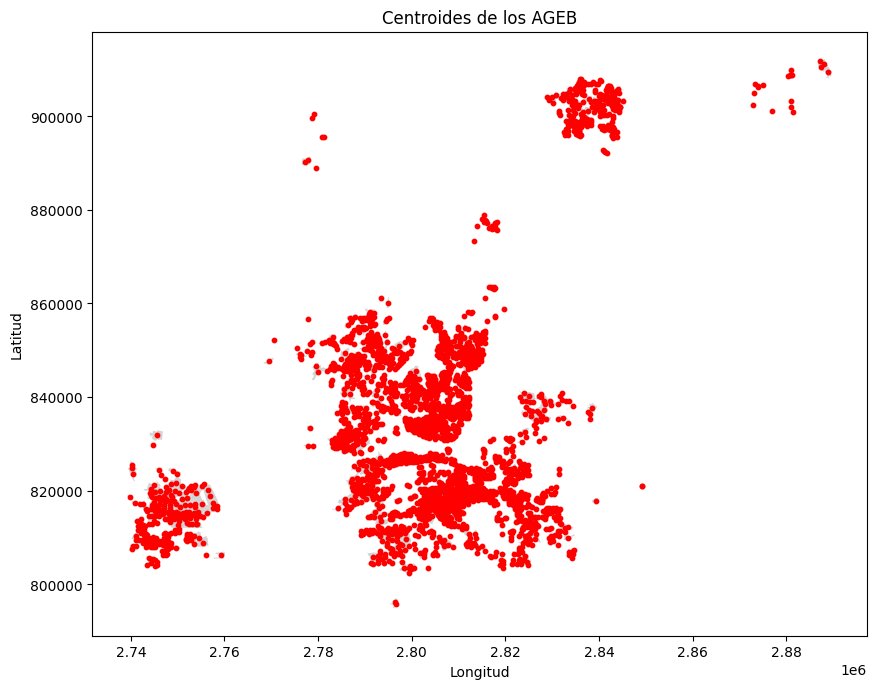

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
agebs_unidos.plot(ax=ax, color='lightgray')
centroides.plot(ax=ax, color='red', markersize=10)


ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.title('Centroides de los AGEB')
plt.show()

CRS de agebs: PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32614"]]
CRS de raster_extent: PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER

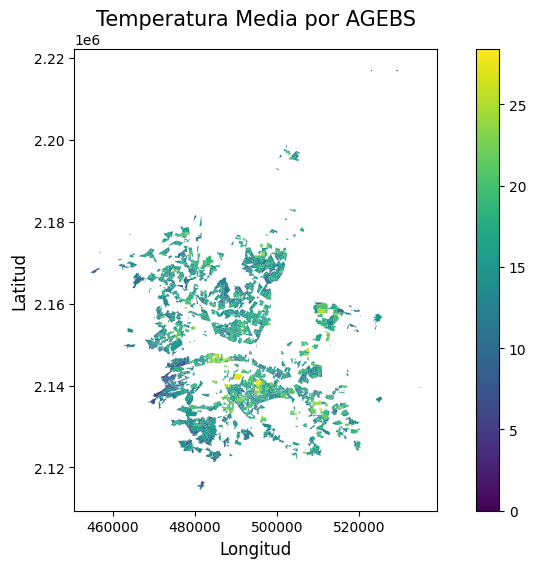

In [44]:
from rasterio.mask import mask
import numpy as np
from shapely.geometry import box
from rasterio.warp import reproject, Resampling


# Abre la imagen raster
img = rio.open('/content/ht_island_cent_Ciudad de México.tif')


# Extrae los datos del raster como un array de NumPy
raster_data = img.read(1)

# Crea un GeoDataFrame desde los límites del raster
raster_bounds = img.bounds
raster_extent = gpd.GeoDataFrame({'geometry': [box(*raster_bounds)]}, geometry='geometry', crs=img.crs)

# Verifica los CRS
print("CRS de agebs:", agebs_unidos.crs)
print("CRS de raster_extent:", raster_extent.crs)

# Reproyecta agebs al CRS de raster_extent
#agebs_unidos = agebs_unidos.to_crs(raster_extent.crs)

# Convirtiendo (MALLAS A AGEBS)
# Reproyectar raster_extent al CRS de agebs
raster_extent = raster_extent.to_crs(agebs_unidos.crs)

# Verifica los CRS
print("CRS de agebs convertido:", agebs_unidos.crs)
print("CRS de raster_extent convertido:", raster_extent.crs)


# Reproyecta el raster al CRS de agebs_unidos
dst_crs = agebs_unidos.crs

# Create a new raster with the desired CRS
with rio.open('/content/ht_island_cent_Ciudad de México_reprojected.tif', 'w',
              driver='GTiff',
              width=img.width,
              height=img.height,
              count=1,
              dtype=raster_data.dtype,
              crs=dst_crs,
              transform=img.transform) as dst:
    reproject(
        source=rio.band(img, 1),
        destination=rio.band(dst, 1),
        src_transform=img.transform,
        src_crs=img.crs,
        dst_transform=img.transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)

# Open the reprojected raster
img = rio.open('/content/ht_island_cent_Ciudad de México_reprojected.tif')

# Realiza una unión espacial para obtener los polígonos que intersectan
intersecting_polygons = gpd.overlay(agebs_unidos, raster_extent, how='intersection')

# Enmascara el raster usando los polígonos que intersectan
masked_data, masked_transform = mask(img, intersecting_polygons.geometry, crop=True)

# Calcula la temperatura media para cada polígono
mean_temperatures = []
for geom in intersecting_polygons.geometry:
    single_mask, single_transform = mask(img, [geom], crop=True)
    mean_temperatures.append(np.mean(single_mask))

# Añade las temperaturas medias al GeoDataFrame
intersecting_polygons['temperatura'] = mean_temperatures

# Fusiona los resultados de vuelta al GeoDataFrame original
agebs_with_temp = agebs_unidos.merge(intersecting_polygons[['centroid', 'temperatura']], on='centroid', how='left')

# Visualiza
ax = agebs_with_temp.plot(column='temperatura', legend=True, figsize=(10, 6))

# Añadiendo título y etiquetas de los ejes
ax.set_title('Temperatura Media por AGEBS', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Mostrar el gráfico
plt.show()




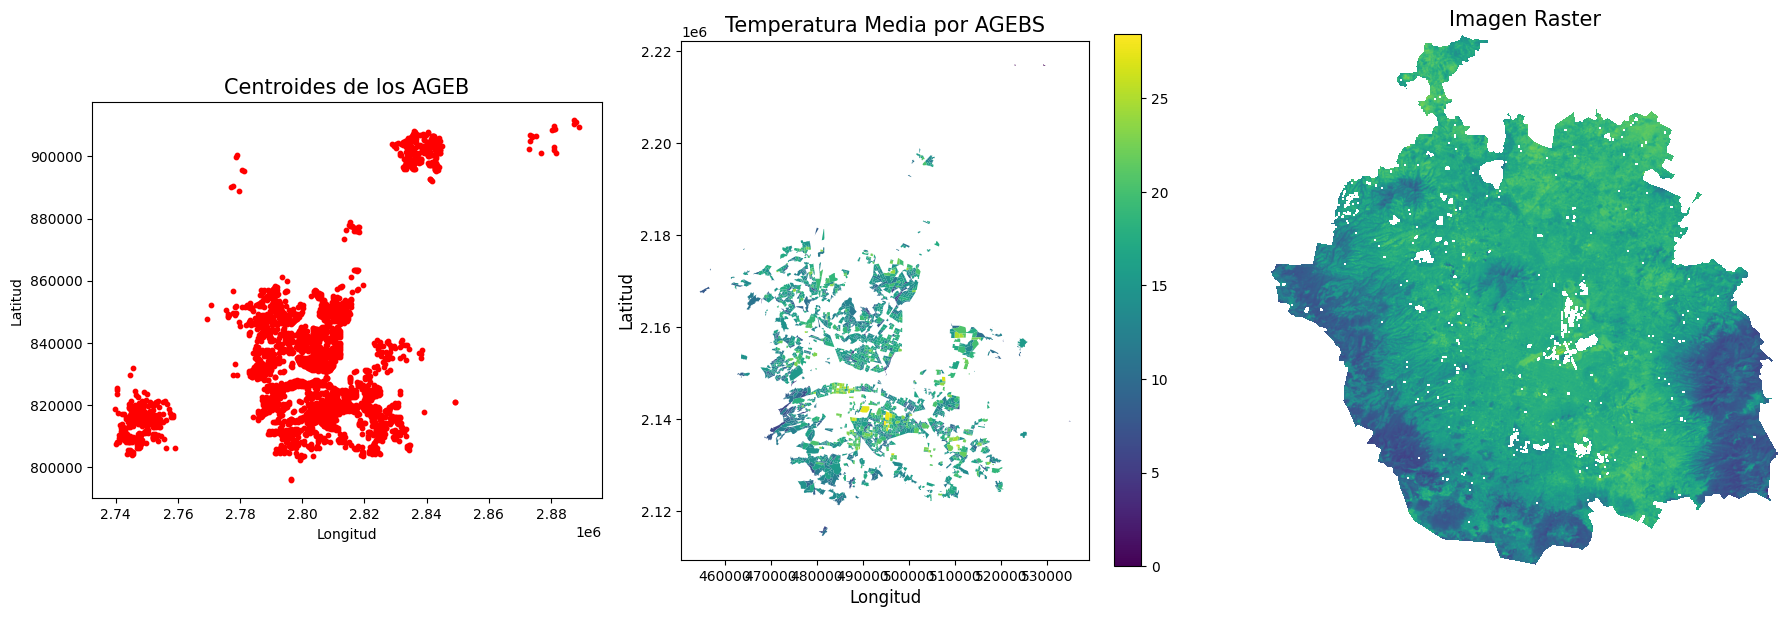

In [45]:
import rasterio
# Crea una figura con tres subgráficas
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Primer gráfico
centroides.plot(ax=axes[0], color='red', markersize=10)
axes[0].set_title('Centroides de los AGEB', fontsize=15)
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

# Segundo gráfico
agebs_with_temp.plot(column='temperatura', ax=axes[1], legend=True)
axes[1].set_title('Temperatura Media por AGEBS', fontsize=15)
axes[1].set_xlabel('Longitud', fontsize=12)
axes[1].set_ylabel('Latitud', fontsize=12)

# Tercera columna: cargar y mostrar una imagen raster
with rasterio.open('/content/ht_island_cent_Ciudad de México.tif') as src:
    imgRaster = src.read(1)  # Leer la primera banda

# Muestra la imagen raster
axes[2].imshow(imgRaster, aspect='auto')
axes[2].axis('off')  # Opcional: desactiva los ejes
axes[2].set_title('Imagen Raster', fontsize=15)

# Ajusta los límites del eje
axes[2].set_xlim(0, img.shape[1])
axes[2].set_ylim(img.shape[0], 0)

# Ajusta el diseño para evitar solapamientos
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

# Muestra los gráficos
plt.show()

In [46]:
print(agebs_unidos.columns)

Index(['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'geometry',
       'POBTOT', 'Promedio_POBTOT', 'centroid'],
      dtype='object')


In [47]:
# Obtener una lista de los identificadores de AGEB
lista_agebs = agebs_unidos['CVE_AGEB'].tolist()  # Ajusta el nombre de la columna si es diferente

print(lista_agebs)

['1716', '2150', '1133', '1307', '2199', '2269', '2273', '1330', '1684', '1665', '2216', '1275', '1063', '1542', '2358', '2057', '2201', '1222', '1364', '1006', '1769', '2042', '1951', '1044', '1129', '1970', '1010', '2362', '1881', '1928', '1966', '2004', '2019', '2038', '2131', '2184', '2292', '1114', '1078', '1190', '1203', '1148', '1519', '1523', '1631', '1646', '1650', '2146', '1453', '1059', '1792', '2377', '2343', '2381', '1824', '1947', '2080', '2108', '2305', '1152', '1186', '1595', '1294', '1985', '1345', '1557', '1561', '1025', '1773', '1805', '1218', '1858', '1699', '1913', '1627', '1260', '1237', '1241', '1580', '1843', '1171', '2254', '2288', '2339', '2023', '2324', '2095', '2220', '2112', '2235', '1434', '2076', '2061', '1472', '1379', '1788', '1839', '2165', '1754', '1720', '1468', '1932', '1487', '1735', '1072', '1424', '2066', '2174', '1994', '1000', '1509', '1763', '2070', '1068', '2121', '1975', '1388', '1956', '1918', '2206', '2155', '2314', '1937', '2193', '1015',

In [48]:
import pandas as pd

# Crear un DataFrame con la lista de AGEBs
df_agebs = pd.DataFrame({'CVE_AGEB': lista_agebs})

# Guardar el DataFrame como un archivo CSV
df_agebs.to_csv('lista_agebs.csv', index=False)

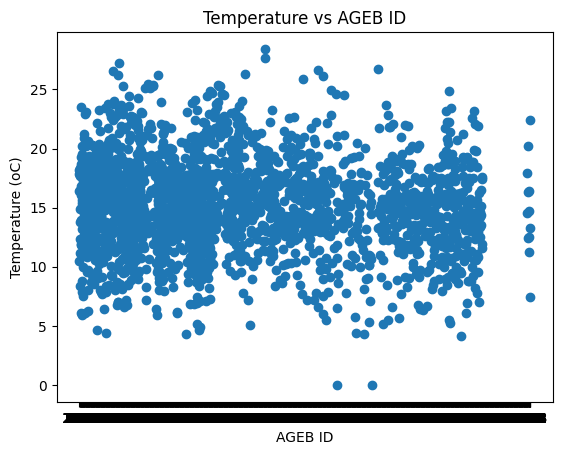

In [49]:
ageb_ids = agebs_with_temp['CVE_AGEB']  # Assuming a column named 'AGEB_ID' exists
temperatures = agebs_with_temp['temperatura']

plt.scatter(ageb_ids, temperatures)
plt.xlabel('AGEB ID')
plt.ylabel('Temperature (oC)')
plt.title('Temperature vs AGEB ID')
plt.show()

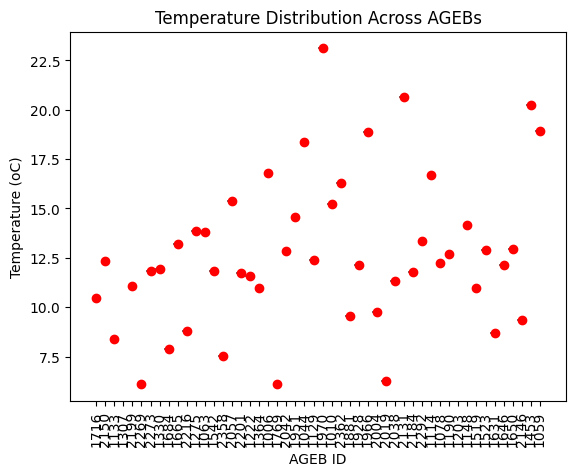

<Figure size 4000x600 with 0 Axes>

In [50]:
import seaborn as sns


# Seleccionamos los primeros 100 AGEBs
primeros_100_agebs = agebs_with_temp.head(50)

# Extraemos las columnas de interés
ageb_ids = primeros_100_agebs['CVE_AGEB']
temperatures = primeros_100_agebs['temperatura']

ax = sns.violinplot(x=ageb_ids, y=temperatures)

# Promedio
means = primeros_100_agebs.groupby('CVE_AGEB')['temperatura'].mean()
plt.plot(means.index, means.values, "o", color='red', label='Mean')

# Customize
plt.xlabel('AGEB ID')
plt.ylabel('Temperature (oC)')
plt.title('Temperature Distribution Across AGEBs')
plt.xticks(rotation=90)
plt.subplots_adjust(wspace=0.5)
plt.figure(figsize=(40, 6))
plt.show()

#Calculando cuartiles de temperatura por AGEB

Los cuartiles dividen un conjunto de datos en cuatro partes iguales. Son una medida de dispersión que nos permite entender mejor cómo se distribuyen los datos.

* Primer cuartil (Q1): El 25% de los datos son menores o iguales a este valor.
* Segundo cuartil (Q2): Es la mediana, el 50% de los datos son menores o iguales a este valor.
* Tercer cuartil (Q3): El 75% de los datos son menores o iguales a este valor.


In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calcular los cuartiles
cuartiles = agebs_with_temp['temperatura'].quantile([0.25, 0.5, 0.75])

# Imprimir los cuartiles
print("Primer cuartil:", cuartiles[0.25])
print("Segundo cuartil (mediana):", cuartiles[0.5])
print("Tercer cuartil:", cuartiles[0.75])

Primer cuartil: 12.808216055806941
Segundo cuartil (mediana): 15.110873987118808
Tercer cuartil: 17.49863222078296


* Primer cuartil (13.09): El 25% de las temperaturas registradas son iguales o inferiores a 13.09 grados. Esto nos indica que un cuarto de las mediciones se encuentran en la parte más fría de la distribución.
* Segundo cuartil (mediana: 15.52): El 50% de las temperaturas son iguales o inferiores a 15.52 grados. Este valor representa el punto medio de los datos, es decir, la temperatura que separa los datos en dos partes iguales.
* Tercer cuartil (18.02): El 75% de las temperaturas son iguales o inferiores a 18.02 grados. Esto significa que el 25% de las temperaturas más altas se encuentran por encima de este valor.

In [52]:
#Obteniendo los 10 maximos valores de temperatura por ageb

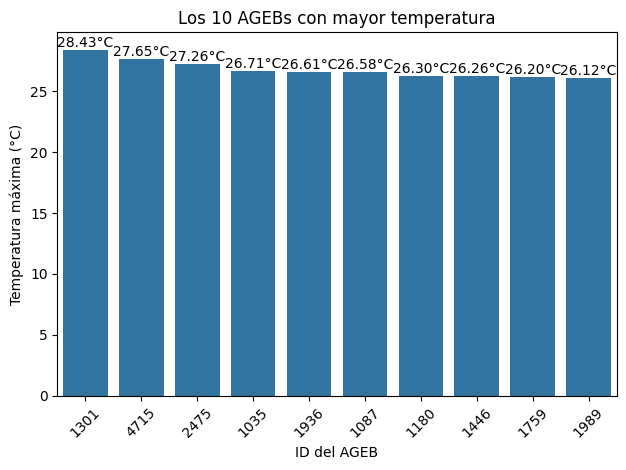

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Order data by temperature (descending)
top_10_agebs = agebs_with_temp.sort_values(by='temperatura', ascending=False).head(10)

# Create the bar plot and get the axes object directly
ax = sns.barplot(x='CVE_AGEB', y='temperatura', data=top_10_agebs)

# Add labels to the bars with formatting
ax.bar_label(ax.containers[0], labels=['{:.2f}°C'.format(val) for val in top_10_agebs['temperatura']])

# Customize the plot
plt.xlabel('ID del AGEB')
plt.ylabel('Temperatura máxima (°C)')
plt.title('Los 10 AGEBs con mayor temperatura')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
#Obteniendo los 10 minimos valores de temperatura por ageb

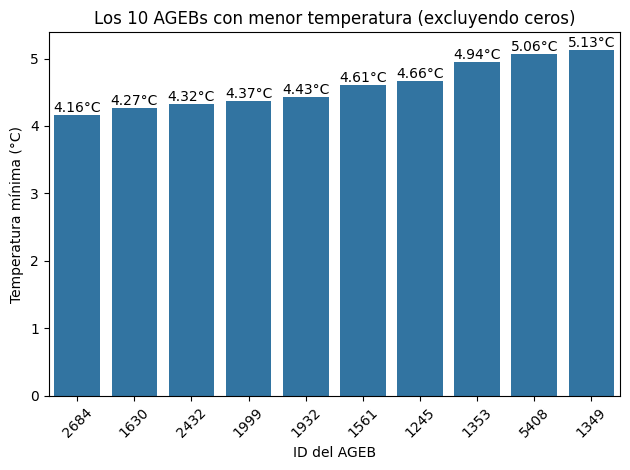

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los datos para excluir los valores 0
top_10_agebs = agebs_with_temp[agebs_with_temp['temperatura'] > 0].sort_values(by='temperatura', ascending=True).head(10)

# Crear el gráfico de barras y obtener el objeto de los ejes directamente
ax = sns.barplot(x='CVE_AGEB', y='temperatura', data=top_10_agebs)

# Agregar etiquetas a las barras con formato personalizado
ax.bar_label(ax.containers[0], labels=['{:.2f}°C'.format(val) for val in top_10_agebs['temperatura']])

# Personalizar el gráfico
plt.xlabel('ID del AGEB')
plt.ylabel('Temperatura mínima (°C)')
plt.title('Los 10 AGEBs con menor temperatura (excluyendo ceros)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()